In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
import pmdarima as pa

Import Sales Data

In [ ]:
df = pd.read_csv("/home/neosoft/Documents/csv_files/google_stock_price.csv")

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
...,...,...,...,...,...,...,...
1254,2017-12-22,1061.109985,1064.199951,1059.439941,1060.119995,1060.119995,755100
1255,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
1256,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
1257,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100


In [ ]:
# Convert Month into Datetime
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


Plot Close Price

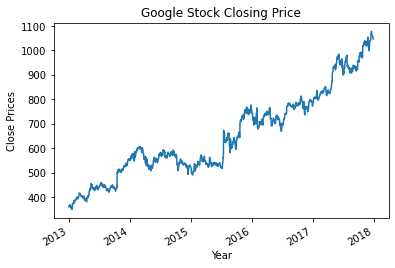

In [ ]:
df['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Close Prices')
plt.title('Google Stock Closing Price')
plt.show()

Cleaning Data

Check for null values

In [ ]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df['Close'].describe()

count    1259.000000
mean      652.657015
std       175.820993
min       349.164032
25%       528.429413
50%       598.005554
75%       772.720001
max      1077.140015
Name: Close, dtype: float64

Testing for stationarity

In [ ]:
def adfuller_test(series):
    adft = adfuller(series, autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4], index=['ADF Test Statistic', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

Decomposing the Time Series

In [ ]:
adfuller_test(df['Close'])

ADF Test Statistic               -0.250610
p-value                           0.932214
No. of lags used                  0.000000
Number of observations used    1258.000000
critical value (1%)              -3.435559
critical value (5%)              -2.863840
critical value (10%)             -2.567995
dtype: float64


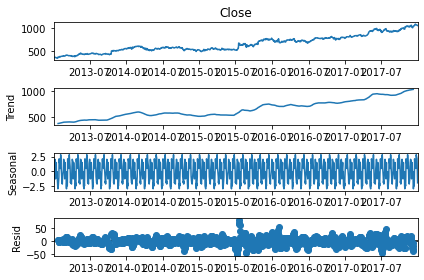

In [ ]:
# To separate the trend and the seasonality from a time series, we can decompose the series
decompose_data = seasonal_decompose(df['Close'], model='additive', period = 30)
decompose_data.plot();

Making time series stationary

d-term

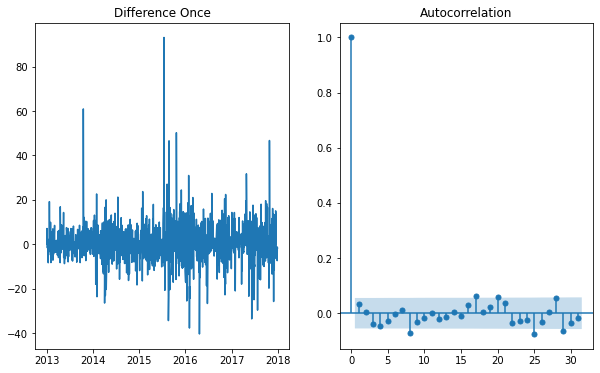

In [ ]:
diff = df['Close'].diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);

In [ ]:
ndiffs(df['Close'], test='adf')

1

In [ ]:
# Again test dickey fuller test
adfuller_test(df['Close'].diff().dropna())

ADF Test Statistic              -34.295913
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    1257.000000
critical value (1%)              -3.435563
critical value (5%)              -2.863842
critical value (10%)             -2.567996
dtype: float64


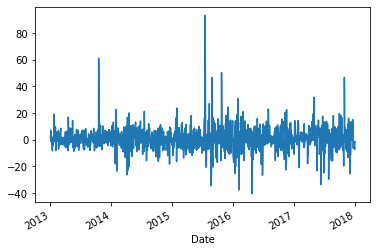

In [ ]:
df['Close'].diff().dropna().plot()
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Google Stock Closing Price')
plt.show()

p-term

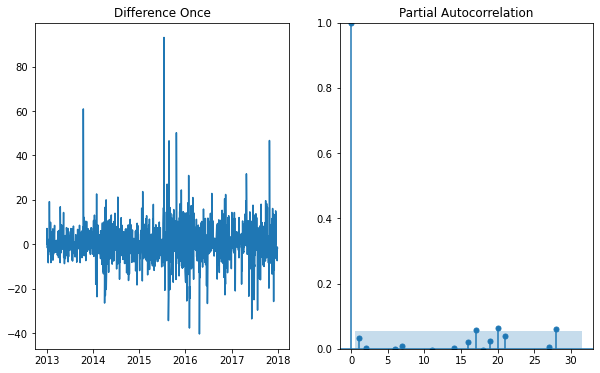

In [ ]:
diff = df['Close'].diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(diff)
ax1.set_title('Difference Once')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

q-term

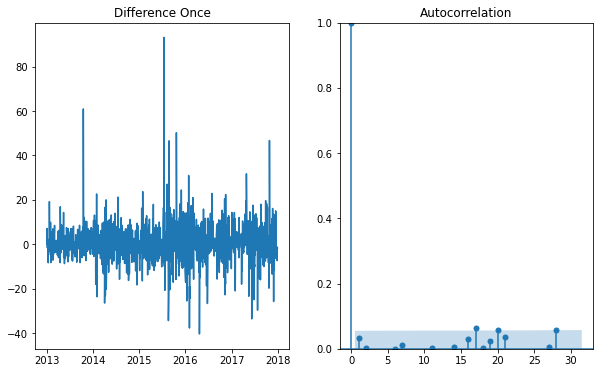

In [ ]:
diff = df['Close'].diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(diff)
ax1.set_title('Difference Once')
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

Fitting the ARIMA Model

In [ ]:
# auto-ARIMA
model = pa.auto_arima(df['Close'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, # maximum p and q
                         m=1, # frequency of series
                         d=None, # let model determine d
                         seasonal=False,  # No Seasonality
                         start_P=0, 
                         D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9034.422, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9031.743, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9032.424, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9032.436, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9034.634, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.559 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4513.872
Date:                Mon, 27 Jun 2022   AIC                           9031.743
Time:                        19:39:49   BIC                           9042.018
Sample:                             0   HQIC                          9035.604
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5462      0.259      2.110      0.035       0.039       1.054
sigma2        76.5841      1.119     68.418      0.000      74.390      78.778
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):             11157.55
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

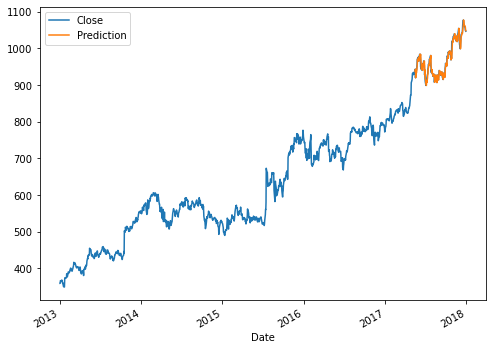

In [ ]:
df['Prediction'] = result.predict(start=1100, end=1258, dynamic=False)
df[['Close', 'Prediction']].plot(figsize=(8, 6))
plt.show()

In [ ]:
# Train test split
n= int(len(df) * 0.8)
train_data = df['Close'][:n]
test_data = df['Close'][n:]
print(len(train_data))
print(len(test_data))

1007
252


In [ ]:
# Forecast
# forecast values and confidence interval for the forecasts
steps = 252
fc, conf = model.predict(steps, return_conf_int=True)  

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

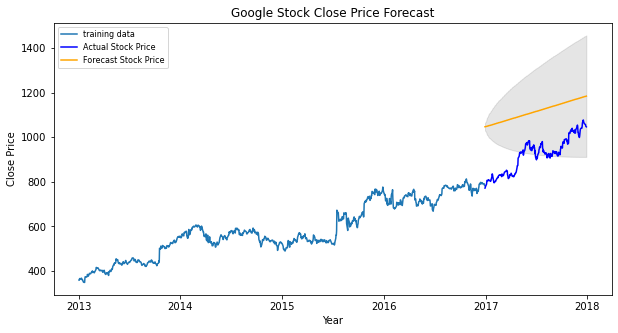

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Forecast Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=0.1)
plt.title('Google Stock Close Price Forecast')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()